In [49]:
# Leaky integrator model of Echo State Network
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

In [50]:
PPL_SIZE = 50
N_NODES = 50
INTERNAL_NODE = 5
N_EDGE = 250
N_TEST = 20
SPECT_RADIUS = 0.93
MUTATION_GROWTH = 15
REWIRING_GROWTH = 30
MATING_GROWTH = 15
W_IN = (np.random.rand(N_NODES, 1) * 2 - 1)*0.1
W_IN[-INTERNAL_NODE:] = [0]

trainlen = 1200
future = 1000
buffer = 100

In [51]:
def correct_dimensions(s, targetlength):
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class LI_ESN_internal:

    def __init__(self, n_inputs, n_outputs, n_reservoir=200, W=None, W_in=None,
                 noise=0.001, input_shift=None,
                 input_scaling=None, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 internal_node=5,
                 random_state=None, time_scale=None):
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.noise = noise
        self.internal_node = internal_node
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state
        self.time_scale = time_scale
        self.W = W
        self.W_in = W_in

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

    def _update(self, state, input_pattern):
        # leaky integrator model:
        # it can adjust timescales for each neurons.
        preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        state = (1 - self.time_scale) * state + self.time_scale * np.tanh(preactivation)
        return (state + self.noise * self.time_scale * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def calc_lyapunov_exp(self, inputs, initial_distance, n):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        states1 = np.zeros((inputs.shape[0], self.n_reservoir))
        states2 = np.zeros((inputs.shape[0], self.n_reservoir))
        transient = min(int(inputs.shape[0] / 10), 100)
        for i in range(1, transient):
            states1[i, :] = self._update(states1[i-1], inputs[i, :])
        states2[transient-1, :] = states1[transient-1, :]
        states2[transient-1, n] = states2[transient-1, n] + initial_distance
        gamma_k_list = []
        for k in range(transient, inputs.shape[0]):
            states1[k, :] = self._update(states1[k-1], inputs[k, :])
            states2[k, :] = self._update(states2[k-1], inputs[k, :])
            gamma_k = np.linalg.norm(states2[k, :]-states1[k, :])
            gamma_k_list.append(gamma_k/initial_distance)
            states2[k, :] = states1[k, :] + (initial_distance/gamma_k)*(states2[k, :]-states1[k, :])
        lyapunov_exp = np.mean(np.log(gamma_k_list))
        return lyapunov_exp
            
    
    def fit(self, inputs, outputs):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        inputs_scaled = inputs
        teachers_scaled = outputs

        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :])
        transient = min(int(inputs.shape[0] / 10), 100)
        
        self.W_out = np.dot(np.linalg.pinv(states[transient:, :-self.internal_node]),teachers_scaled[transient:, :]).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
            
        # apply learned weights to the collected states:
        pred_train = np.dot(states[:, :-self.internal_node], self.W_out.T)
        return pred_train

    def predict(self, inputs, continuation=True):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, inputs])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :])
            outputs[n + 1, :] = np.dot(self.W_out,states[n + 1, :-self.internal_node])

        return self.out_activation(outputs[1:])


In [52]:
def make_data_for_narma(length):
    tau = 0.01
    buffer = 100
    x = np.random.rand(length+100)*0.5
    y = np.zeros(length)
    for i in range(length):
        if i < 29:
            y[i] = 0.2*y[i-1] + 0.004*y[i-1]*np.sum(np.hstack((y[i-29:], y[:i]))) + 1.5*x[i-29+100]*x[i+100] + 0.001
        else:
            y[i] = 0.2*y[i-1] + 0.004*y[i-1]*np.sum(np.hstack((y[i-29:i]))) + 1.5*x[i-29+100]*x[i+100] + 0.001
    return x, y

In [53]:
def make_init_ppl(spectral_radius):
    population = []
    for i in range(PPL_SIZE):
        W = np.random.normal(0, 1/N_NODES, N_NODES**2)
        tmp = np.random.choice(N_NODES**2, N_EDGE, replace=False)
        mask = [False if i in tmp else True for i in range(N_NODES**2)]
        mask = np.array(mask)
        W[mask] = 0
        W = W.reshape(N_NODES, N_NODES)
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        W = W * (spectral_radius / radius)
        population.append([W, 0.0])
    # population = np.array(population)
    return population

In [54]:
time_scale = np.ones(N_NODES)
time_scale[-3:] = 0.1
def generation(time_scale, population, n_ppl=PPL_SIZE, n_test=N_TEST):
    data_pool = []
    for i in range(len(population)):
        esn = LI_ESN_internal(n_inputs=1,
                              W=population[i][0],
                              W_in=W_IN,
                              n_outputs=1,
                              n_reservoir=N_NODES,
                              noise=0,
                              internal_node=INTERNAL_NODE,
                              time_scale=time_scale)
        fitness_list = []
        for k in range(n_test):
            data, target = make_data_for_narma(trainlen+future)
            pred_training = esn.fit(data[buffer:buffer+trainlen], target[:trainlen])
            prediction = esn.predict(data[trainlen+buffer:])
            fitness = np.sqrt(np.mean((np.reshape(prediction, -1)-np.reshape(target[trainlen:], -1))**2)/np.var(target[trainlen:]))
            fitness_list.append(fitness)
        # print(np.mean(fitness_list))
        population[i][1] = np.mean(fitness_list)
    return population

In [55]:
def mutation(population, n_growth=MUTATION_GROWTH, n_ppl=PPL_SIZE):
    for i in np.random.choice(n_ppl, n_growth, replace=False):
        tmp_W = population[i][0].reshape(N_NODES**2)
        while True:
            mutation_index = np.random.choice(N_NODES**2)
            if abs(tmp_W[mutation_index]) > 0:
                break
        # dist_range = 0.1*abs(tmp_W[mutation_index])
        # tmp_W[mutation_index] = tmp_W[mutation_index] + dist_range*(np.random.rand()*2-1)
        tmp_W[mutation_index] = 0.5*(np.random.rand()*2-1)
        population.append([tmp_W.reshape((N_NODES, N_NODES)), 0.0])
    return population

In [56]:
def rewiring(population, n_growth=REWIRING_GROWTH, n_ppl=PPL_SIZE):
    for i in np.random.choice(n_ppl, n_growth, replace=False):
        tmp_W = population[i][0].reshape(N_NODES**2)
        while True:
            rewiring_index = np.random.choice(N_NODES**2)
            if abs(tmp_W[rewiring_index]) > 0:
                break
        if np.random.rand() > 0.5:
            j = rewiring_index % N_NODES
            new_rewiring_index = np.random.choice(N_NODES)*N_NODES+j
        else:
            i = rewiring_index // N_NODES
            new_rewiring_index = i*N_NODES + np.random.choice(N_NODES)
        tmp_saved = tmp_W[new_rewiring_index]
        tmp_W[new_rewiring_index] = tmp_W[rewiring_index]
        tmp_W[rewiring_index] = tmp_saved
        population.append([tmp_W.reshape((N_NODES, N_NODES)), 0.0])
    return population

In [57]:
def mating(population, n_growth=MATING_GROWTH, n_ppl=PPL_SIZE):
    for n in range(n_growth):
        i, j = np.random.choice(n_ppl, 2, replace=False)
        overlap = []
        oneside_tuple = []
        parent1 = population[i][0].reshape(N_NODES**2)
        parent2 = population[j][0].reshape(N_NODES**2)
        for k in range(N_NODES**2):
            if parent1[k]*parent2[k] != 0:
                overlap.append(k)
            elif parent1[k] != 0 or parent2[k] != 0:
                oneside_tuple.append((1 if parent1[k] != 0 else 2, k))
        new_W = np.zeros(N_NODES**2)
        if len(overlap) > 0:
            for edge_index in overlap:
                new_W[edge_index] = parent1[edge_index] if np.random.rand() > 0.5 else parent2[edge_index]
        if len(oneside_tuple) > 0:
            selected_index = np.random.choice(len(oneside_tuple), N_EDGE-len(overlap), replace=False)
            for edge_index in selected_index:
                new_W[oneside_tuple[edge_index][1]] = parent1[oneside_tuple[edge_index][1]] if oneside_tuple[edge_index][0]==1 else parent2[oneside_tuple[edge_index][1]]
        population.append([new_W.reshape((N_NODES, N_NODES)), 0.0])
    return population

In [60]:
def natural_selection(population, n_ppl=PPL_SIZE):
    fitness_list = [population[i][1] for i in range(len(population))]
    argsort = np.argsort(fitness_list)
    population = np.array(population)
    sorted_population = population[argsort, :]
    population_strong = sorted_population[:n_ppl-10]
    print('best_fitness:', sorted_population[0][1],sorted_population[1][1], sorted_population[2][1], 'average_fitness:', np.mean([population[i][1] for i in range(n_ppl)]))
    population_strong = population_strong.tolist()
    population_random_idx = np.random.choice(len(population), 10)
    population_random = [population[idx] for idx in population_random_idx]
    population = population_strong+population_random
    return population

In [59]:
new_population = make_init_ppl(SPECT_RADIUS)
# print(new_population)
for generation_idx in range(300):
    new_population = mating(new_population)
    new_population = rewiring(new_population)
    new_population = mutation(new_population)
    new_population = generation(time_scale, new_population)
    print(generation_idx+1)
    new_population = natural_selection(new_population)

1
best_fitness: 0.6692591408810457 0.6712617664928964 0.6811607327294541 average_fitness: 0.7155623472558819
2
best_fitness: 0.6712817674962777 0.6733851447334731 0.6792342522132835 average_fitness: 0.7040889288535369
3
best_fitness: 0.6603600203218012 0.6607627884746512 0.6635863064219025 average_fitness: 0.6943632505850755
4
best_fitness: 0.6548924192452549 0.6552881001467031 0.6563432253051437 average_fitness: 0.6870967427218686
5
best_fitness: 0.6698032768397738 0.6746932467131718 0.6752671937831447 average_fitness: 0.6929690369216176
6
best_fitness: 0.6751981431378319 0.6786575334772083 0.6860380314071393 average_fitness: 0.7188868951583554
7
best_fitness: 0.6725647763333616 0.678415610088231 0.682800899027753 average_fitness: 0.7140401812987194
8
best_fitness: 0.6786164261344576 0.680408893986912 0.68479235204759 average_fitness: 0.7064851973699046
9
best_fitness: 0.6780171650863223 0.6781872316779055 0.6832596075189594 average_fitness: 0.6958996439878092
10
best_fitness: 0.66538

76
best_fitness: 0.6049111039672284 0.6065302426790138 0.6069227275709261 average_fitness: 0.6196556410175604
77
best_fitness: 0.6025985280967541 0.6091188335872733 0.6093123852679485 average_fitness: 0.6177320984120735
78
best_fitness: 0.6083872674673463 0.6089938507096297 0.6092015256441957 average_fitness: 0.6147958540217856
79
best_fitness: 0.6056362314387128 0.6069647164860245 0.6074970983268956 average_fitness: 0.61585753285345
80
best_fitness: 0.6070195458008875 0.6092073419989846 0.6098706077021486 average_fitness: 0.6182779383114071
81
best_fitness: 0.6018140667615836 0.6034305204580722 0.6063869101155519 average_fitness: 0.6166182624665235
82
best_fitness: 0.5975651337769959 0.599287133226893 0.6000492310355205 average_fitness: 0.6171936029741673
83
best_fitness: 0.5992758925111716 0.600495106429371 0.6017531167986852 average_fitness: 0.6134946259259138
84
best_fitness: 0.6041716652400339 0.6043011031303428 0.605632865463157 average_fitness: 0.6166265335603328
85
best_fitness

151
best_fitness: 0.5865605434523032 0.5895628470094688 0.5915386844248055 average_fitness: 0.5998053170126003
152
best_fitness: 0.5822968108520017 0.5906849099211726 0.5932611169243133 average_fitness: 0.6116941746220674
153
best_fitness: 0.5898475483691887 0.596129416875657 0.5966598430733968 average_fitness: 0.6239785655236214
154
best_fitness: 0.5914169210288194 0.5920143292696883 0.5935302939989202 average_fitness: 0.6139385061001374
155
best_fitness: 0.5803583052038932 0.5811972147565123 0.5825296938189473 average_fitness: 0.6095906447940346
156
best_fitness: 0.5756583186056952 0.5813791309177835 0.5856468514404611 average_fitness: 0.6065389835423179
157
best_fitness: 0.5812390714255804 0.5813053016451238 0.5818066469865026 average_fitness: 0.6018248389557725
158
best_fitness: 0.5812877051638188 0.5834323620626555 0.5958286390941911 average_fitness: 0.6028086335978654
159
best_fitness: 0.5786833635337746 0.5804111846532727 0.5808479211381488 average_fitness: 0.6147614106847485
16

226
best_fitness: 0.5569675591097789 0.558976689531983 0.5613267090998901 average_fitness: 0.56921060695466
227
best_fitness: 0.5620741473480423 0.5629379033143638 0.5655601518822948 average_fitness: 0.5710784230801516
228
best_fitness: 0.5540612171487014 0.5573535131499819 0.5605453333377659 average_fitness: 0.5779175474188046
229
best_fitness: 0.5581030950222785 0.5652784829181476 0.5657939659464873 average_fitness: 0.5784366405337557
230
best_fitness: 0.5604525712144777 0.5617800586274524 0.5657417183422507 average_fitness: 0.5765900099035325
231
best_fitness: 0.5612404915438725 0.5617343426067313 0.564176068977157 average_fitness: 0.5775190344922803
232
best_fitness: 0.5595121272969645 0.5622748451719223 0.5682610666595707 average_fitness: 0.5864680845282141
233
best_fitness: 0.5531063560350372 0.557602196456035 0.5631382178367778 average_fitness: 0.582646223583115
234
best_fitness: 0.5544283257678913 0.561876607864735 0.5621811215875341 average_fitness: 0.5777131747506585
235
best

In [37]:
radius = np.max(np.abs(np.linalg.eigvals(new_population[11][0])))
print(radius)

0.9066798163381802


In [20]:
np.save('population_for_normal_network.npy', new_population)

In [21]:
new_population2 = generation(time_scale, new_population)

In [22]:
print(new_population2)

[[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.87630323],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.18746968,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.35759463, ...,  0.        ,
         0.19459977, -0.16527331],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), 0.5161555822031533], [array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.87630323],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.18746968,  0.        ,  0.        , ...

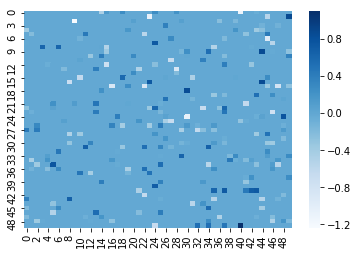

In [17]:
import seaborn as sns
sns.heatmap(new_population[0][0], cmap='Blues')

In [ ]:
# speciationして構造を保護したほうがいいかもしれない。
# タスクの選定は大事。J_ijの違いがパフォーマンスに強く影響を与える設定が望ましい。
# noiseを加えるのは考えてみてもいいかも。
# sparsityを変えてみるとか。
# W_inも最適化させた方がいい気がする。